In [84]:
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [85]:
# Getting the ticker of the stock that the user wants to work with. 
ticker = input("Please enter the ticker that you want to analyse: ")

In [86]:
# Getting the ticker stock price
stock = yf.Ticker(ticker.upper())
# Querying all the data from a very long time ago. 
stock_history = stock.history(period='20y')
# Dropping the Dividends and the Stock Split column.
stock_histroy = stock_history.drop(['Dividends', 'Stock Splits'], axis=1)

In [87]:
#####################################################
## SPLITTING THE DATASET INTO TRAINING AND TESTING ##
#####################################################
# Using the inbuilt train_test_split function to split the data.
# training_data, testing_data = sklearn.model_selection.train_test_split(stock_history, test_size = 1/8, train_size = 7/8, shuffle=False)
training_data = stock_history.loc[f"{2010}":f"{2020}"]
testing_data = stock_history.loc[f"{2021}":]

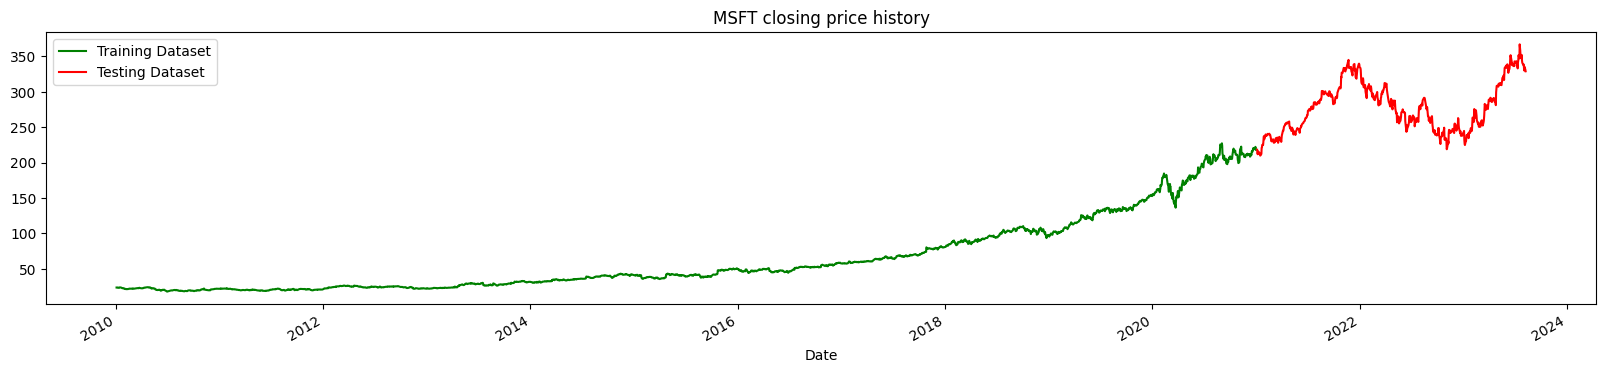

In [88]:
#########################################################################################
## CREATING A PLOT TO SHOW THE STOCK PRICE WE WILL USE TO TRAIN AND THOSE USED TO TEST ##
#########################################################################################
# Plotting the training data
training_data['High'].plot(figsize=(20,4), legend=True, color='green')
# Plotting the testing data.
testing_data['High'].plot(figsize=(20,4), legend=True, color='red')
# Adding legends and title to the graph below
plt.title(f"{ticker} closing price history")
plt.legend(['Training Dataset', 'Testing Dataset'])

In [89]:
##################################
## SCALING OUR TRAINING DATASET ##
##################################
# Mkaing a minmaxsclaer object. We want to scale the data, such that it is in the interval of 0-1, this setting parameters accordingly.
scaler = MinMaxScaler(feature_range=(0,1))
# Reshaping the pandas series that we are intersted in which is the closing price. 
training_data_close = training_data['High'].values.reshape(-1,1)
# Scaling the training data.
training_data_scaled = scaler.fit_transform(training_data_close)

In [90]:
################################################
## SPLITTING THE DATASET INTO SMALLER SAMPLES ##
################################################
"""
The idea is to split the timeseries data ito steps that would lead to several input timestamp, and one output timestamp.
The reason for this is to account for the fact that every datapoint is dependent on the datapoint on the previous timestamp.
This helps us split our dataset into smaller samples.
"""

def sequence_split(data: np.ndarray, steps: int) -> np.ndarray:
    """
        The function splits a timesequence such that for a number of steps, the previous datapoints, lead to an output datapoint.

        Args:
            data: The dataset that we want to split.
            steps: The number of datapoints we want to have in our input, before we have an output.
        Returns:
            Two numpy array, one containing the steps and the other containing the output.
    """
    input_list, output_list = [], []
    for index, datapoint in enumerate(data):
        last_input_datapoint = index + steps
        if last_input_datapoint > len(data)-1:
            break
        input_list.append(data[index: last_input_datapoint])
        output_list.append(data[last_input_datapoint])
    final_input_array = np.array(input_list)
    final_output_array = np.array(output_list)
    return final_input_array, final_output_array

In [91]:
########################################################
## CALLING THE sequence_split FUNCTION ON OUR DATASET ##
########################################################
# Setting the number of steps to be decently high. We can adjust this to get a better performing model.
x_train, y_train = sequence_split(training_data_scaled, 100)
# Shaping the training data such that is it (A,B,1). We use 1 as we have a time series that consists of a single scalar observation in a sequenctial manner that incrmeents over equal time intervals. 
x_train_reshaped = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [92]:
##################################
## LONG-SHORT TERM MEMORY MODEL ##
##################################
# Making the Sequential object.
lstm_model = Sequential()
# Adding a later to the model. They layer has an activation funciotn of tanh, and input shape of (steps, no_of_features) --> from previous cell.
lstm_model.add(LSTM(units = 150, activation='tanh', input_shape=(100, 1)))
# Adding a dense layer to the lSTM model, with 1 output unit.
lstm_model.add(Dense(units=1))
# Compiling the model. 
lstm_model.compile(optimizer='RMSprop', loss="mse")
# Getting a model summary.
lstm_model.summary()
# Fitting the data to the model.
""" 
    Epochs -> The number of times that we want to interate over the entire dataset.
    batch_size -> The number of samples that are prcoessed before updating the model's weights.
"""
lstm_model.fit(x_train_reshaped, y_train, epochs=65, batch_size=15)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 150)               91200     
                                                                 
 dense_6 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91351 (356.84 KB)
Trainable params: 91351 (356.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/65
178/178 [==============================] - 5s 26ms/step - loss: 0.0025
Epoch 2/65
178/178 [==============================] - 5s 26ms/step - loss: 5.4261e-04
Epoch 3/65
178/178 [==============================] - 5s 26ms/step - loss: 3.9087e-04
Epoch 4/65
178/178 [==============================] - 5s 26ms/step - loss: 3.3940e-04
Epoch 5/65
178/178 [==============================] - 5s 25ms/step - los

In [94]:
##############################################
## TESTING OUR MODEL USING THE TESTING DATA ##
##############################################
testing_data_input = stock_history[len(stock_history)-len(testing_data)-100:]
testing_data_close = testing_data_input['High'].values.reshape(-1,1)
testing_data_scaled = scaler.transform(testing_data_close)
x_test, y_test = sequence_split(testing_data_scaled, 100)
x_test_reshaped = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
# Making a prediction for our test dataset.
predicted_closing_price = lstm_model.predict(x_test_reshaped)
# Need to inverse transform the values
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

21/21 [==============================] - 0s 10ms/step


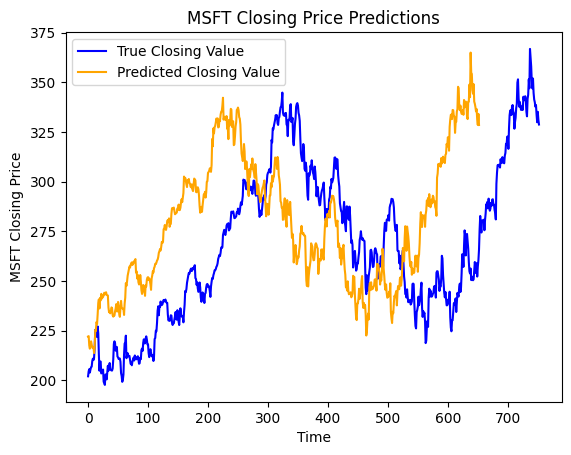

In [95]:
############################################################################
## PLOTTING THE ACTUAL TEST OUTPUT VALUES AND THE PREDICTED OUTPUT VALUES ##
############################################################################
plt.plot(testing_data_close, color='blue', label='True Closing Value')
plt.plot(predicted_closing_price, color='orange', label='Predicted Closing Value')
plt.title(f"{ticker} Closing Price Predictions")
plt.xlabel("Time")
plt.ylabel(f"{ticker} Closing Price")
plt.legend()
plt.show()